In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

import model_based_agent as mba 
import worm_env as we 
import ensemble_mod_env as eme

from improc import *
import utils as ut
import tab_agents as tab
from datetime import datetime 

In [9]:
def make_dist_dict2(df, sm_pars=None,
    prev_act_window=3,
    lp_frac=None):
    # This version doesn't smooth reward matrices. First subtracts them and then smooths the resulting matrix.
    # Stores difference in r_on and adds variances; sets r_off to 0's. 
    # Makes a dictionary of distributions using trajectory statistics.
    # sm_pars is a dict of form {'lambda': .05, 'iters': 30}
    #     If None, then no smoothing.
    # Lp_frac: [0,1]. Models find a number to subtract from light-on matrices, in order for
    #  this fraction of observations to remain above their corresponding light-off spots.

    traj_on = df.query('prev_actions=='+str(prev_act_window))
    traj_off = df.query('prev_actions==0')

    r_on, b_on, h_on, count_on = ut.make_stat_mats(traj_on)
    r_off, b_off, h_off, count_off = ut.make_stat_mats(traj_off)

    all_mats = [r_on,b_on,h_on,r_off,b_off,h_off]
    counts = [count_on,count_off]
    counts_lp = counts[0]+counts[1]

    for i in [1,2,4,5]:
        for j in range(2):
            if j==1:
                ang_par = False 
            else:
                ang_par = True
            all_mats[i][:,:,j] = ut.lin_interp_mat(all_mats[i][:,:,j], ang_par)
            
            if sm_pars is not None:
                all_mats[i][:,:,j] = ut.smoothen(all_mats[i][:,:,j], 
                                                counts[i//3], ang_par, 
                                                smooth_par=sm_pars['lambda'], iters=sm_pars['iters'])
                
    # Turns r_on and r_off matrices into their differences stored in r_on. (r_off is now set to 0)
    r_on[:,:,0] = r_on[:,:,0]-r_off[:,:,0]
    r_on[:,:,1] = r_on[:,:,1]+r_off[:,:,1]
    for i in range(2):
        r_on[:,:,i] = ut.lin_interp_mat(r_on[:,:,i], False)
    r_on[:,:,0] = ut.smoothen(r_on[:,:,0], counts_lp, False, smooth_par=sm_pars['lambda']*5, iters=sm_pars['iters'])
    r_off = np.zeros(r_off.shape)
    
    # This block is for light penalty implementation. Only applied to r_on.
    if lp_frac is None:
        light_penalty = 0
    else:
        r_diffs = r_on[:,:,0]-r_off[:,:,0]
        r_diffs_sorti = np.unravel_index(np.argsort(-r_diffs,axis=None), r_on[:,:,0].shape) # Subtract means and gets sorted indices.
        r_diffs_sorted = r_diffs[r_diffs_sorti]
        #counts_lp = np.ones((12,12)) ############
        count_lim = np.sum(counts_lp)*lp_frac
        cs = np.cumsum(counts_lp[r_diffs_sorti]) < count_lim
        cutoff_ind = [i for i,x in enumerate(cs) if not x][0]
        light_penalty = r_diffs_sorted[cutoff_ind]
        print(f'Penalty {light_penalty}')

    dist_dict = {
        'body_on': b_on,
        'body_off': b_off,
        'head_on': h_on,
        'head_off': h_off,
        'reward_on': r_on - light_penalty,
        'reward_off': r_off,
    }    
    return dist_dict

def plot_mods(models,vmin=None,vmax=None):
    fig,ax = plt.subplots(len(models),7)
    fig.set_size_inches((15,2*len(models)))
    for m,mod in enumerate(models):
        for i,(key,item) in enumerate(mod.items()):
            if i<4:
                img = ax[m,i].imshow(item[:,:,0],vmin=-180,vmax=180)
            else:
                img = ax[m,i].imshow(item[:,:,0],vmin=vmin,vmax=vmax)
            fig.colorbar(img,ax=ax[m,i])
            ax[m,i].axis('off')
            if m==0:
                ax[m,i].set_title(f'{len(models)} models: {key}')
        ax[m,6].imshow(np.sign(mod['reward_on'][:,:,0]-mod['reward_off'][:,:,0]),vmin=-1,vmax=1)

In [11]:
folders = ['./Data/HTFix19-01-18-47/',
           './Data/HTFix19-01-20-29/',
           './Data/HTFix19-01-21-18/',
           './Data/HTFix20-01-09-04/',
          ]

dh = mba.DataHandler()
dh.load_df(folders[0]+'alls.pkl')
for f in folders[1:]:
    dh.add_df_to_df([f+'alls.pkl'])

In [12]:
dh.df

,t,obs_b,angs,prev_actions,reward,loc,target,obs_h,next_obs_b,next_obs_h
0,0.984,-30,"[90, 270]",3,6.421441,"[1007.8554216867469, 1002.0602409638554]",90,30.0,-30.0,30.0
1,1.172,-30,"[90, 270]",2,6.134315,"[1008.2528735632184, 1000.9195402298851]",90,30.0,-30.0,30.0
2,1.375,-30,"[90, 270]",1,6.425035,"[1008.3827160493827, 1000.469135802469]",90,30.0,-30.0,30.0
3,1.562,-30,"[90, 240]",0,6.587415,"[1008.6585365853659, 999.7317073170732]",90,30.0,-30.0,30.0
4,1.765,-30,"[90, 240]",0,6.356707,"[1008.6470588235295, 999.3764705882354]",90,30.0,-30.0,60.0
...,...,...,...,...,...,...,...,...,...,...
30773,297.688,120,"[0, 180]",3,-8.406176,"[1184.8, 1061.3]",180,60.0,120.0,90.0
30774,297.891,120,"[30, 180]",3,-8.851376,"[1186.0648148148148, 1062.0740740740741]",180,90.0,120.0,120.0
30775,298.094,120,"[60, 180]",3,-8.000606,"[1187.5765765765766, 1062.7477477477478]",180,120.0,120.0,120.0
30776,298.250,120,"[60, 180]",3,-7.432514,"[1188.1944444444443, 1063.3240740740741]",180,120.0,120.0,120.0


In [27]:
mod = make_dist_dict2(dh.df,sm_pars={'lambda':.1,'iters':10},prev_act_window=3,lp_frac=.4)

Penalty 0.30102462423132054


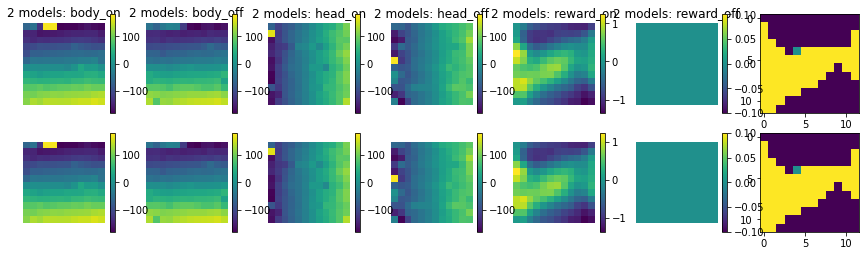

In [28]:
mods_plt = [mod,mod]
plot_mods(mods_plt)

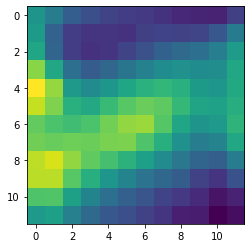

In [29]:
plt.imshow(mod['reward_on'][:,:,0])